In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (e.g. sklearn and seaborn)


# Reading train data
df_complete = pd.read_csv('./dataset/data_undertood.csv', index_col=0)

In [12]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1497 entries, 38 to 16144
Data columns (total 21 columns):
user_id                                 1497 non-null int64
monthly_income                          1497 non-null int64
monthly_outcome                         1497 non-null int64
class                                   1497 non-null int64
institution                             1497 non-null object
account_type                            1497 non-null object
credit_type                             1497 non-null object
total_credit_payments                   1497 non-null float64
payment_frequency                       1497 non-null object
amount_to_pay_next_payment              1497 non-null float64
account_opening_date                    1497 non-null object
maximum_credit_amount                   1497 non-null float64
current_balance                         1497 non-null float64
credit_limit                            1497 non-null float64
worst_delinquency_date              

 #  The good and the bad client:

In this notebook we make a ML classifier to filter loans,
that will generate delinquncies.  

To this end, we create the binary target feature:

loan_test $=$  (worst_delinquency_past_due_estimated / loan_amount) $<$ 0.1

This feature will classify with (1) or (0) a loan which 
generated or not an accumulated delinquency 
larger than 10 % of the agreed lent money.

Crucially, in order to deal with clients with delinquency records, we like
to predict potential_loan without using the delinquency records. 

In what follows, we prepare data for this aim. 

Of course, the result will be an approximate model, dealing with an 
random process. We shall use the data basis of clients, to see estimate 
losses, and propose an interest rate to get the business going.

In [13]:
# Create feature 
df= df_complete;

delinquency_acceptance_threshold = 0.1

df['loan_test'] = (df['worst_delinquency_past_due_estimated'] / df['loan_amount'] 
                        <= delinquency_acceptance_threshold ).astype(int)



In [14]:
records = df[ (df['worst_delinquency_date'] != 'No') & (df['worst_delinquency_date'] != 'Missing')] 

records = records[['user_id', 'worst_delinquency_date','worst_delinquency_past_due_estimated','loan_amount']];



In [15]:
from datetime import datetime as dt 

def past_dates(date , date_list):
    
    past_list = []
    
    for i in date_list:
        if i < date: 
            past_list.append(i)

    
    return past_list


def worst_previous_record(col):
    
    user_id = col[0]
    account_opening_date = dt.strptime(col[1], "%m/%d/%y")
    
    user_records = records[records['user_id'] == user_id]
    
    keys = [dt.strptime(i, "%m/%d/%y") for i in user_records.worst_delinquency_date ]
    
    values_amount = [i for i in user_records.worst_delinquency_past_due_estimated  ]
    
    amount_dict = dict(zip(keys, values_amount))

    past_list = past_dates(account_opening_date , keys)
    
    if past_list == []: 
        return 0
    
    else:
        return max([amount_dict[i] for i in past_list])
    

df['worst_previous_delinquency'] = df[['user_id','account_opening_date']].apply(worst_previous_record, axis = 1)

In [16]:
def worst_fraction_record(col):
    
    user_id = col[0]
    account_opening_date = dt.strptime(col[1], "%m/%d/%y")
    
    user_records = records[records['user_id'] == user_id]
    
    keys = [dt.strptime(i, "%m/%d/%y") for i in user_records.worst_delinquency_date ]
    
    
    values_fraction = [i for i in (user_records.worst_delinquency_past_due_estimated
                                  /user_records.loan_amount)  ]

    fraction_dict = dict(zip(keys, values_fraction))
    

    past_list = past_dates(account_opening_date , keys)
    
    if past_list == []: 
        return 0
    
    else:
        return  max([fraction_dict[i] for i in past_list])
    
df['worst_previous_fraction'] = df[['user_id','account_opening_date']].apply(worst_fraction_record, axis = 1)

In [17]:
# So, when an user ask for loan, we want to be predict it if will 
# pay, 

df=df.drop(columns = ['worst_delinquency_date', 
                   'worst_delinquency_past_due_estimated', 
                   'worst_delinquency_estimated', 
                   'current_balance',
                   'payment_frequency',
                   'account_type',
                   'amount_to_pay_next_payment',
                   'class',
                   '_has_account_closing_date',
                   'institution', # A generalisation should include it
                   'user_id',
                   'maximum_credit_amount',
                   'credit_limit']);

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1497 entries, 38 to 16144
Data columns (total 11 columns):
monthly_income                1497 non-null int64
monthly_outcome               1497 non-null int64
credit_type                   1497 non-null object
total_credit_payments         1497 non-null float64
account_opening_date          1497 non-null object
payments_per_year             1497 non-null int64
loan_term                     1497 non-null float64
loan_amount                   1497 non-null float64
loan_test                     1497 non-null int64
worst_previous_delinquency    1497 non-null float64
worst_previous_fraction       1497 non-null float64
dtypes: float64(5), int64(4), object(2)
memory usage: 140.3+ KB


# Categorical variables

### account_opening_date

We create one bin open_recently that encodes this function (>recent_threhold). Future generalisations should 
group opening dates sistematically in order to improve modeling accuracy. 

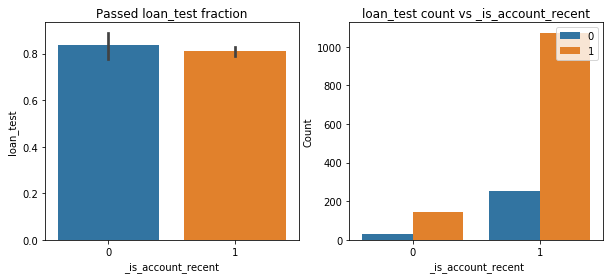

In [49]:
recent_threhold = 8  # 20XX

def turn_date_binary(col):
    date = int(col[0][-2:])
    if (date <= 18) & (date >= recent_threhold): return 1
    else: 
        return 0

df['_is_account_recent']=df[['account_opening_date']].apply(turn_date_binary, axis = 1)



def loan_test_and_count_vs(feature_str):
    """
    Arguments: 
    feature_str -- Categorica feature of df
    Return:
    Countplot -- For each label of feature_str
    Class Ratio plot -- For each value of feature_str
    """
    fig, ax = plt.subplots(1 , 2, figsize=(10, 4))
    
    
    axx=ax.flat

    g1=sns.catplot(x=feature_str,y='loan_test',data=df,kind="bar",ax=axx[0])
    g1.set_ylabels("loan_test")
    axx[0].set_title('Passed loan_test fraction')

    plt.close(2);
    axx[1]=sns.countplot(x = feature_str, hue = 'loan_test', data = df)
    axx[1].set_title('loan_test count vs '+feature_str)

    axx[1].set_xlabel(feature_str)
    axx[1].set_ylabel('Count')
    axx[1].legend(['0','1'],loc = 1)
    
    
loan_test_and_count_vs('_is_account_recent')

 #### Insights:
 These plots show that actually, the fraction passed our loan_test is independent
 of whether the clients account was oppened recently or not. But most of our records
 have recent opening account date.

### credit_type

In [30]:
pd.value_counts(df.credit_type).to_frame()

,credit_type
Préstamo Personal,770
Aparatos - Muebles,199
Línea de Crédito,156
Compra de Automóvil,83
Crédito al Consumo,69
Crédito Fiscal,39
Préstamo de Nomina,33
Otros (Múltiples Créditos),30
Arrendamiento Automotriz,30
Grupo Solidario,17


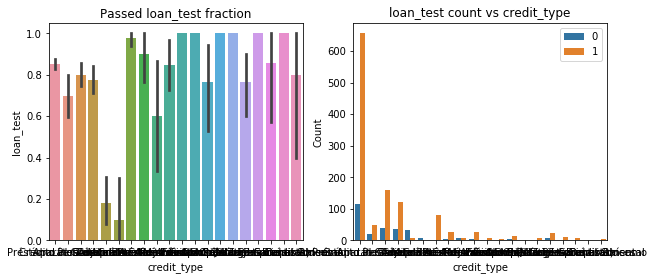

In [50]:
loan_test_and_count_vs('credit_type')

#### Insights:
From this plot it is clear that different credit types have different loan_test fractions. Further work
should aim to groups with similar ration/count values. For now we only single out the two common credit types: "Préstamo Personal"

In [52]:
df['_is_common_type'] = df[(df.credit_type=='Préstamo Personal') | (df.credit_type=='Aparatos - Muebles') ]
df['_is_common_type']

ValueError: Wrong number of items passed 12, placement implies 1